## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [222]:
import skimage.io as io
import skimage as skim
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt

In [223]:
# Creo una función auxiliar para eliminar los ejes y el recuadro al hacer plt show()
def show_img(img, title, grey=False):
    if grey:
        plt.imshow(img, cmap="grey")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.show()

In [224]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Visualizar la imagen

def abrir_imagen(path):
    img = io.imread(path)
    show_img(img, "Imagen original")
    return img

In [225]:
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]

def normalizar_imagen(img):
# Para normalizar, puesto que la imagen viene descrita en código RGB, esto es,
# un pixel es una tripleta de valores comprendidos entre 0 y 255, dividimos entre 255 cada una de las componentes
    im_norm = img.astype('uint8')/255
    show_img(im_norm, "Imagen normalizada")
    return im_norm

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [226]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

def extraer_magenta(img):
# Para extraer la componente magenta, primero pasamos a CMYK acorde a las ecuaciones vistas en clase
# en im1_norm y im2_norm tenemos las imagenes normalizadas [0,1], por lo que no hace falta volver a hacer la división
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(img, axis=2)
        C = (1-img[:,:,0]-K)/(1-K)
        M = (1-img[:,:,1]-K)/(1-K)
        Y = (1-img[:,:,2]-K)/(1-K)

    CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
    _, img_mag, _, _ = cv2.split(CMYK)
    show_img(img_mag, "Componente magenta")

    return img_mag

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

def umbralizar_imagen(img):
    # Filtro Gaussiano de tamaño 5x5 con variación estandar 0
    img_gauss = cv2.GaussianBlur(img.astype('uint8'), (5,5), 0)
    img_threshold, img_mask = cv2.threshold(img_gauss, 0, 1, cv2.THRESH_OTSU)
    # Hacemos esta sustitución para preparar el siguiente apartado adecuadamente
    img_mask = np.where(img_mask==0, 255, img_mask)
    img_mask = np.where(img_mask==1, 0, img_mask)
    show_img(img_mask, "Imagen umbralizada, Threshold de OTSU: " + str(img_threshold), grey=True)
    return img_mask

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
def limpiar_artefacto(img):
    img_limpia = skim.morphology.remove_small_objects(img.astype(bool), min_size=300)
    show_img(img_limpia, "Imagen umbralizada limpia de artefactos", grey=True)
    return img_limpia

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas.
# Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

def extraer_lumen(img):
    h, w = img.shape
    mask_ref = np.zeros((h+2, w+2), np.uint8)
    img_rell = skim.segmentation.flood_fill(img, (15,15), 0)
    img_rell = skim.segmentation.flood_fill(img_rell, (1000,1000), 0)
    show_img(img_rell, "Lúmenes en blanco, fondo negro", grey=True)
    return img_rell

#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
def rellenar_lumen(img):
    img_rell=scipy.ndimage.morphology.binary_fill_holes(img)
    show_img(img_rell, "Lúmenes rellenos", grey=True)
    return img_rell


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

def buscar_contorno(img_original, img_rell):
    #Buscamos los contornos en la imagen con los lúmenes rellenos generada en el apartado anterior
    contornos, _ = cv2.findContours(img_rell.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_cont = img_original.copy()
    # Con un grosor de 5 unidades, garantizamos que el contorno sea perfectamente visible
    cv2.drawContours(img_cont, contornos, -1, (0, 255, 0), 5) 

    show_img(img_cont, "Contornos de los lúmenes")
    return contornos

#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
def get_max_lumen(img_original, contornos):
    max_cont = max(contornos, key=cv2.contourArea)
    min_x, min_y, len_x, len_y = cv2.boundingRect(max_cont)
    max_lumen = img_original[min_y:min_y+len_y, min_x:min_x+len_x]
    show_img(max_lumen, "Lumen más grande recortado")
    return max_lumen


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad


def get_propiedades(lumen):

    print("Área: " + str(round(skim.measure.regionprops(lumen)[0].area,4)))
    print("Área de la bounding box: " + str(round(skim.measure.regionprops(lumen.astype('uint8'))[0].bbox_area,4)))
    print("Área convexa: " + str(round(skim.measure.regionprops(lumen.astype('uint8'))[0].convex_area,4)))
    print("Exentricidad: " + str(round(skim.measure.regionprops(lumen[0].astype(np.uint8))[0].eccentricity,4)))
    print("Diámetro equivalente: " + str(round(skim.measure.regionprops(lumen.astype('uint8'))[0].equivalent_diameter,4)))
    print("Extensión: " + str(round(skim.measure.regionprops(lumen)[0].extent,4)))
    print("Diámetro Feret: " + str(round(skim.measure.regionprops(lumen)[0].feret_diameter_max,4)))
    print("Longitud del eje mayor: " + str(round(skim.measure.regionprops(lumen)[0].major_axis_length,4)))
    print("Longitud del eje menor: " + str(round(skim.measure.regionprops(lumen)[0].minor_axis_length,4)))
    print("Orientación: " + str(round(skim.measure.regionprops(lumen)[0].orientation,4)))
    print("Perímetro: " + str(round(skim.measure.regionprops(lumen)[0].perimeter,4)))
    print("Solidez: " + str(round(skim.measure.regionprops(lumen)[0].solidity,4)))
    # Para la compacidad usamos la fórmula de la compacidad: Area^2/area
    print("Compacidad: " + str(round(skim.measure.regionprops(lumen)[0].perimeter ** 2 / skim.measure.regionprops(lumen)[0].area,4)))
    return

In [ ]:
def imagenes_tejido(path):
    img = abrir_imagen(path)
    img_norm = normalizar_imagen(img)
    img_mag = extraer_magenta(img_norm)
    img_umb = umbralizar_imagen(img_mag)
    img_limp = limpiar_artefacto(img_umb)
    img_lum = extraer_lumen(img_limp)
    img_rell = rellenar_lumen(img_lum)
    contornos = buscar_contorno(img, img_rell)
    lumen = get_max_lumen(img, contornos)
    get_propiedades(lumen)

Analizando imagen 1


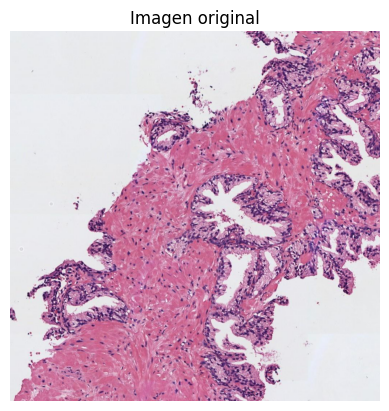

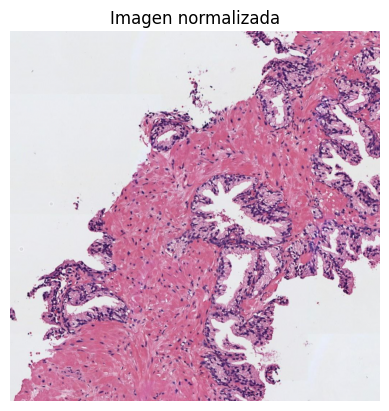

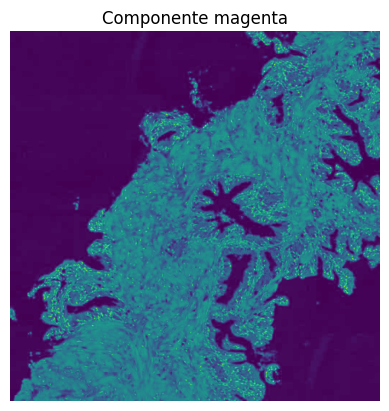

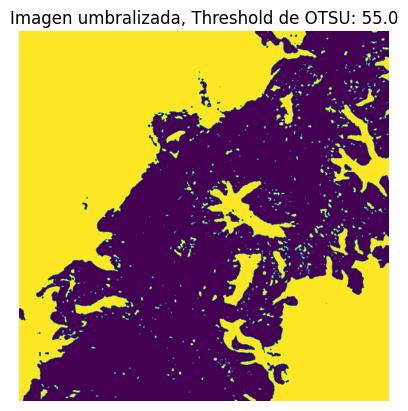

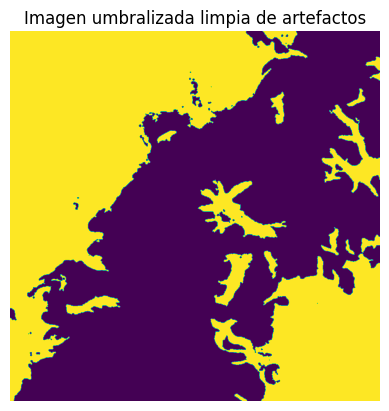

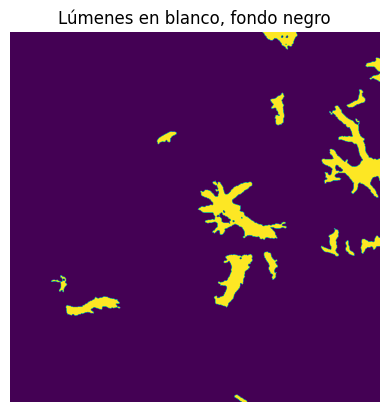

C:\Users\manus\AppData\Local\Temp\ipykernel_22440\2011455928.py:4: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  img_rell=scipy.ndimage.morphology.binary_fill_holes(img)


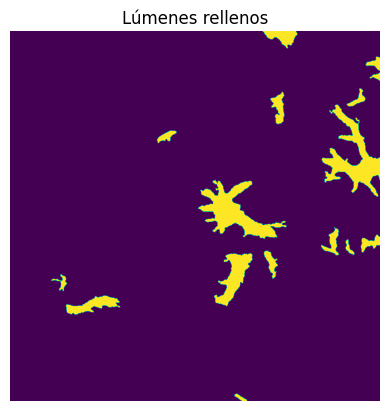

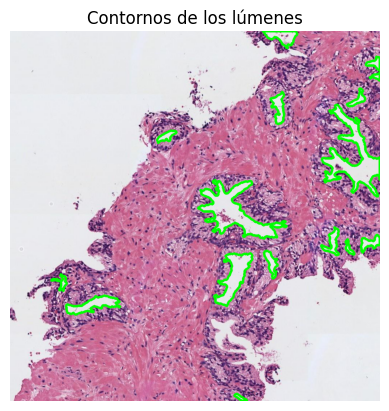

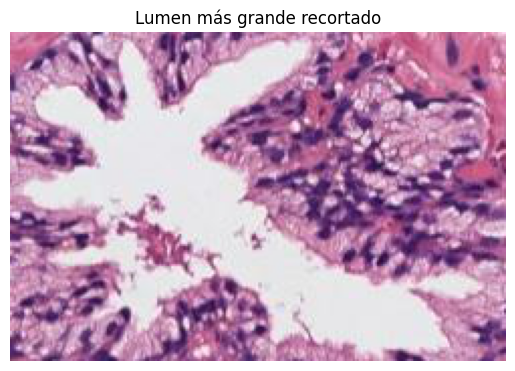

Área: 1.0
Área de la bounding box: 1.0
Área convexa: 0.0
Exentricidad: 0
Diámetro equivalente: 1.2407
Extensión: 1.0


C:\Users\manus\anaconda3\Lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1740350360  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)


ValueError: Surface level must be within volume data range.

In [ ]:

path_img = "images/"
path_im1 = "histo_1.jpg"
path_im2 = "histo_2.jpg"
print("Analizando imagen 1")
imagenes_tejido(path_img + path_im1)
print('\n\n-------------------------------\n\n')
print("Analizando imagen 2")
imagenes_tejido(path_img + path_im2)